# Predict Adverse Drug Reactions with the LINCS L1000 data

---


## _Zichen Wang, Avi Ma'ayan_

<img src="http://lincs-dcic.org/images/dcic-logo/DCIC_500x375_cropped.png" style="float: right; width: 100px;"/>

#### BD2K-LINCS Data Coordination and Integration Center

#### CMap Workshop - Dec. 4th, 2018 

---

## Table of content 

- [1. Prepare datasets for the Machine Learning task]()
- [2. Train and validate multi-label classification model to predict ADRs]()

![](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4965635/bin/btw168f1p.jpg)

Wang Z, Clark NR, Ma'ayan A (2016) _Bioinformatics_ [doi: 10.1093/bioinformatics/btw168](https://www.ncbi.nlm.nih.gov/pubmed/27153606)

## Intro to multi-label classification
![img from my slides]()

In [1]:
# Set paths to find the data required
DATA_DIR = '/srv/data/workshop/data/common'
# DATA_MODULE3_DIR = '/srv/data/workshop/data/Module3'
DATA_MODULE3_DIR = '/home/jupyter-zichen.wang@mssm.e-1ae7d/Zichen/data'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import print_function, division
import os, sys
import h5py
import numpy as np
import pandas as pd
from sklearn import decomposition, manifold

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='talk', style='white')

In [4]:
import plots
import gctx_utils

# 1. Prepare datasets for machine learning 

## 1.1. Prepare level 5 signatures for drugs/compounds

- load metadata for genes and signatures

In [5]:
gctx5 = h5py.File('%s/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx' % DATA_DIR, 'r')

In [7]:
gene_info_df = pd.read_csv('%s/GSE92742_Broad_LINCS_gene_info.txt' % DATA_DIR, 
                          sep='\t')
gene_info_df.set_index(gene_info_df.columns[0], inplace=True)
gene_info_df.index = gene_info_df.index.astype(str)
print(gene_info_df.shape)
# Get the Landmark 1000 genes
LM_GENE_IDS = gene_info_df.query('pr_is_lm == 1').index
LM_GENE_IDS = LM_GENE_IDS.values.astype(np.str) # convert to np.array with np.str as dtype
print('Number of landmark genes', len(LM_GENE_IDS))

(12328, 4)
Number of landmark genes 978


In [8]:
sig_info_df = pd.read_csv('%s/GSE92742_Broad_LINCS_sig_info.txt' % DATA_DIR, 
                          sep='\t')
sig_info_df = sig_info_df.set_index('sig_id')
print(sig_info_df.shape)

# Get compound treatment signatures in PC3 cell line
sig_info_df = sig_info_df.query('cell_id == "PC3" & pert_type == "trt_cp"')
print(sig_info_df.shape)

/opt/tljh/user/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.



(473647, 11)
(23123, 11)


In [9]:
sig_info_df.nunique()

pert_id           11150
pert_iname        10661
pert_type             1
cell_id               1
pert_dose          1392
pert_dose_unit        1
pert_idose           27
pert_time             2
pert_time_unit        1
pert_itime            2
distil_id         23123
dtype: int64

## 1.2. Load chemical fingerprints for drugs/compounds

In [10]:
drugs_fp_df = pd.read_csv('%s/MACCS_bitmatrix.csv.gz' % DATA_MODULE3_DIR, 
                         compression='gzip',
                         ).set_index('pert_id')
drugs_fp_df.shape

(41774, 166)

In [11]:
drugs_fp_df.head()

,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,MACCS_9,MACCS_10,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
pert_id,,,,,,,,,,,,,,,,,,,,,
BRD-A00037023,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
BRD-A00051892,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,0,1,1
BRD-A00100033,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,1
BRD-A00150179,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,1,1,1
BRD-A00214921,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


## 1.3. Load drug-ADR connections from SIDER

In [12]:
sider_df = pd.read_csv('%s/SIDER_PTs.csv.gz' % DATA_MODULE3_DIR, 
                      compression='gzip'
                      ).set_index('pert_id')
sider_df.shape

(834, 3165)

In [13]:
sider_df.head()

,Vulvovaginal disorder,Cardiac failure,Thalassaemia,Peritoneal haemorrhage,Cardiac murmur,Judgement impaired,Jaundice,Plasmodium falciparum infection,Influenza like illness,Ingrown hair,...,Phobia,Rash maculo-papular,Oesophageal candidiasis,Blepharitis,Muscle contractions involuntary,Echolalia,Dysplasia,Hypermagnesaemia,Ileus,Blood bilirubin increased
pert_id,,,,,,,,,,,,,,,,,,,,,
BRD-A00546892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A00827783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A01320529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A01636364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A01643550,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.4. Find drugs/compounds that are shared among the three datasets

In [15]:
!pip install --user matplotlib-venn

    100% |████████████████████████████████| 40kB 31.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for matplotlib-venn ... done
  Stored in directory: /home/jupyter-zichen.wang@mssm.e-1ae7d/.cache/pip/wheels/d8/88/2f/e41518cb16e58109e8d14dc5dd7ef8166c82dce86c7c6d6c80
Successfully built matplotlib-venn
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
from matplotlib_venn import venn3, venn2

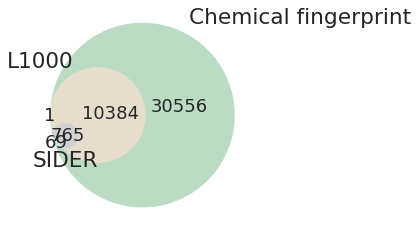

In [18]:
venn3([set(sig_info_df.pert_id), set(drugs_fp_df.index), set(sider_df.index)],
      ('L1000', 'Chemical fingerprint', 'SIDER')
     );

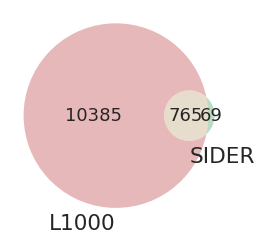

In [19]:
venn2([set(sig_info_df.pert_id), set(sider_df.index)],
      ('L1000', 'SIDER')
     );

In [20]:
shared_drugs = set(sig_info_df.pert_id) & set(drugs_fp_df.index) & set(sider_df.index)
shared_drugs = sorted(shared_drugs)
print(len(shared_drugs))

765


In [21]:
sig_info_df = sig_info_df.loc[sig_info_df['pert_id'].isin(shared_drugs)]
sig_info_df.shape

(2723, 11)

In [22]:
# Retrieve L1000 signatures from the level 5 data
X_L1000 = gctx_utils.slice_matrix(gctx5, rids=LM_GENE_IDS, 
                                  cids=sig_info_df.index.values.astype(np.str))
X_L1000.shape

(2723, 978)

In [23]:
from sklearn import decomposition

In [24]:
pca = decomposition.PCA(n_components=50)
X_L1000_pca = pca.fit_transform(X_L1000)
X_L1000_pca.shape

(2723, 50)

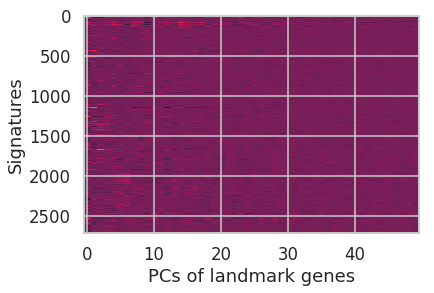

In [27]:
plt.imshow(X_L1000_pca, aspect='auto')
plt.ylabel('Signatures')
plt.xlabel('PCs of landmark genes');

In [28]:
# Subset chemical fingerprint matrix
X_CS = drugs_fp_df.loc[sig_info_df['pert_id']].values
# remove zero features
X_CS = X_CS[:, X_CS.sum(axis=0) > 0]
X_CS.shape

(2723, 154)

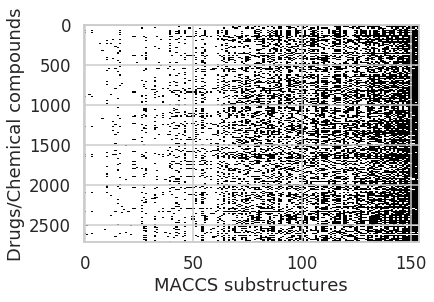

In [30]:
plt.imshow(X_CS, aspect='auto', cmap='binary');
plt.ylabel('Drugs/Chemical compounds')
plt.xlabel('MACCS substructures');

In [31]:
pca = decomposition.TruncatedSVD(n_components=50)
X_CS_pca = pca.fit_transform(X_CS)

In [32]:
# Subset SIDER matrix
Y = sider_df.loc[sig_info_df['pert_id']].values
Y.shape

(2723, 3165)

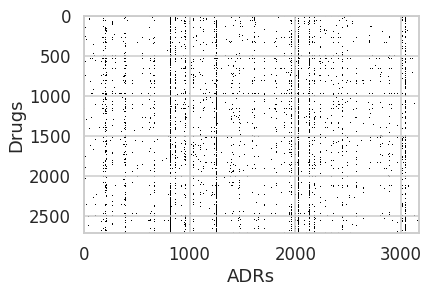

In [33]:
plt.imshow(Y, aspect='auto', cmap='binary')
plt.ylabel('Drugs')
plt.xlabel('ADRs');

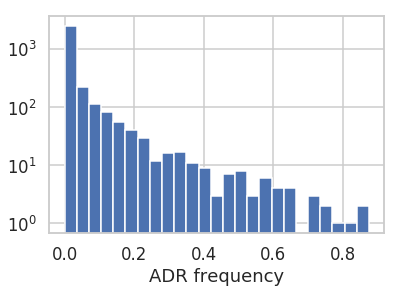

In [34]:
# Examine label (ADR) frequencies
freqs_ADR = Y.mean(axis=0)
plt.hist(freqs_ADR, bins=25, log=True)
plt.xlabel('ADR frequency');

In [35]:
# Examine frequent ADRs
ADRs_freq_df = pd.DataFrame({'frequency': freqs_ADR}, 
                            index=sider_df.columns)

ADRs_freq_df.sort_values('frequency', ascending=False).head(10)

,frequency
Nausea,0.874770
Rash,0.854939
Vomiting,0.827029
Headache,0.791039
Pain,0.762027
Diarrhoea,0.742196
Oedema,0.723467
Dizziness,0.719427
Pruritus,0.710981
Hypersensitivity,0.651855


In [36]:
# Examine infrequent ADRs
ADRs_freq_df.query('frequency > 0').sort_values('frequency').head(10)

,frequency
Brain abscess,0.000367
Hepatoblastoma,0.000367
Serum sickness-like reaction,0.000367
Ear pruritus,0.000367
Ovarian neoplasm,0.000367
Haemorrhagic anaemia,0.000367
Renal cell carcinoma,0.000367
Tooth deposit,0.000367
Ovarian germ cell teratoma benign,0.000367
Hypercoagulation,0.000367


In [37]:
# Exclude ADRs that are too infrequent or frequent
mask_ADR_to_predict = (freqs_ADR > 0.2) & (freqs_ADR < 0.7)

Y = Y[:, mask_ADR_to_predict]
Y.shape

(2723, 143)

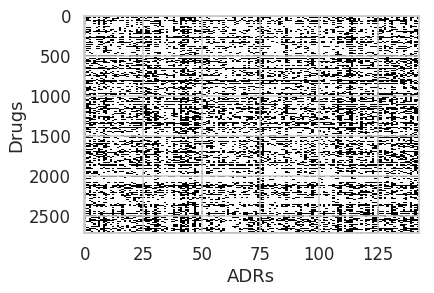

In [39]:
plt.imshow(Y, aspect='auto', cmap='binary');
plt.ylabel('Drugs')
plt.xlabel('ADRs');

# 2. Train and validate multi-label classification model to predict ADRs

In [40]:
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain
from skmultilearn.ensemble import RakelD
from skmultilearn.adapt import MLkNN, MLARAM
from sklearn import linear_model, ensemble, metrics
from sklearn.model_selection import GroupKFold

In [41]:
def cross_validate_ml_clf(ml_clf, cv, X, Y, groups):
    '''
    
    groups: the same group (signatures of the same compound) will not appear 
        in two different folds to avoid over-estimation of predictive performance.
    '''
    
    i = 0 
    scores_df = pd.DataFrame(columns=['hamming_loss', 'accuracy', 'F1'])
    label_aurocs = np.zeros(Y.shape[1])
    
    for train_idx, valid_idx in cv.split(X, Y, groups):
        X_train, X_valid = X[train_idx], X[valid_idx]
        Y_train, Y_valid = Y[train_idx], Y[valid_idx]
        print(X_train.shape, Y_train.shape)
        print(X_valid.shape, Y_valid.shape)
        ml_clf.fit(X_train, Y_train)

        Y_valid_pred = ml_clf.predict(X_valid)
        if type(Y_valid_pred) != np.ndarray:
            Y_valid_pred = Y_valid_pred.toarray() # convert sparse matrix to dense
        
        hamming_loss = metrics.hamming_loss(Y_valid, Y_valid_pred)
        acc = metrics.accuracy_score(Y_valid.ravel(), Y_valid_pred.ravel())
        f1 = metrics.f1_score(Y_valid, Y_valid_pred, average='micro')
        print('Fold %d, hamming loss=%.4f, accuracy=%.4f, F1=%.4f'% (i, hamming_loss, acc, f1))
        scores_df.loc[i] = [hamming_loss, acc, f1]

        Y_valid_pred_probas = ml_clf.predict_proba(X_valid)
        if type(Y_valid_pred_probas) != np.ndarray:
            Y_valid_pred_probas = Y_valid_pred_probas.toarray() # convert sparse matrix to dense
        
        # Per-label AUROC scores        
        aurocs = metrics.roc_auc_score(Y_valid, Y_valid_pred_probas, average=None)
        label_aurocs += aurocs / cv.n_splits
        
        i += 1
    return scores_df, label_aurocs

In [42]:
cv = GroupKFold(n_splits=3)

## 2.1. Examine the performances of a few multi-label classification algorithms

- Binary Relevance (BR)
- Classifier Chain (CC)
- Distinct RAndom k-labELsets multi-label classifier (RAkELd)

In [43]:
rf = ensemble.RandomForestClassifier(n_estimators=20, n_jobs=5)
br_rf = BinaryRelevance(
    classifier=rf
)

In [44]:
scores_df, label_aurocs = cross_validate_ml_clf(br_rf, cv, X_L1000_pca, Y, 
                                                groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.3338, accuracy=0.6662, F1=0.3573
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.3247, accuracy=0.6753, F1=0.3713
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.3463, accuracy=0.6537, F1=0.3652


In [45]:
cc_rf = ClassifierChain(
    classifier=rf
)

In [46]:
scores_df2, label_aurocs2 = cross_validate_ml_clf(cc_rf, cv, X_L1000_pca, Y,
                                                 groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.3437, accuracy=0.6563, F1=0.1064
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.3216, accuracy=0.6784, F1=0.1329
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.3576, accuracy=0.6424, F1=0.1421


In [47]:
rakeld = RakelD(base_classifier=rf,
               base_classifier_require_dense=[True, True],
               labelset_size=3)

In [48]:
scores_df3, label_aurocs3 = cross_validate_ml_clf(rakeld, cv, X_L1000_pca, Y,
                                                 groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.3423, accuracy=0.6577, F1=0.3034
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.3289, accuracy=0.6711, F1=0.3365
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.3503, accuracy=0.6497, F1=0.3367


/home/jupyter-zichen.wang@mssm.e-1ae7d/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



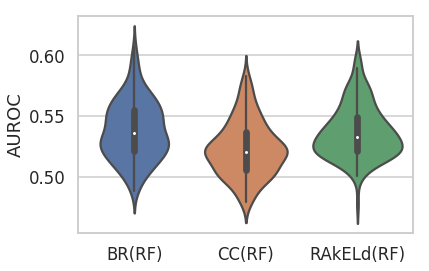

In [49]:
ax = sns.violinplot(data=pd.DataFrame({'BR(RF)': label_aurocs, 
                                  'CC(RF)': label_aurocs2,
                                  'RAkELd(RF)': label_aurocs3,                                       
                                 }))
ax.set_ylabel('AUROC');

## 2.2. Cross-validate classifier on different subset of features 
- L1000 signatures
- fingerprints
- combinations

In [50]:
scores_df_GE, aurocs_GE = cross_validate_ml_clf(br_rf, cv, X_L1000_pca, Y, 
                                                groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.3345, accuracy=0.6655, F1=0.3558
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.3242, accuracy=0.6758, F1=0.3702
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.3461, accuracy=0.6539, F1=0.3672


In [51]:
scores_df_CS, aurocs_CS = cross_validate_ml_clf(br_rf, cv, X_CS_pca, Y, 
                                                groups=sig_info_df.pert_id)

(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 0, hamming loss=0.2947, accuracy=0.7053, F1=0.4385
(1815, 50) (1815, 143)
(908, 50) (908, 143)
Fold 1, hamming loss=0.2636, accuracy=0.7364, F1=0.4853
(1816, 50) (1816, 143)
(907, 50) (907, 143)
Fold 2, hamming loss=0.2694, accuracy=0.7306, F1=0.5311


In [52]:
scores_df_GECS, aurocs_GECS = cross_validate_ml_clf(br_rf, cv, np.hstack((X_L1000_pca, X_CS_pca)), Y,
                                                   groups=sig_info_df.pert_id)

(1815, 100) (1815, 143)
(908, 100) (908, 143)
Fold 0, hamming loss=0.3018, accuracy=0.6982, F1=0.4195
(1815, 100) (1815, 143)
(908, 100) (908, 143)
Fold 1, hamming loss=0.2619, accuracy=0.7381, F1=0.4889
(1816, 100) (1816, 143)
(907, 100) (907, 143)
Fold 2, hamming loss=0.2732, accuracy=0.7268, F1=0.5204


/home/jupyter-zichen.wang@mssm.e-1ae7d/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



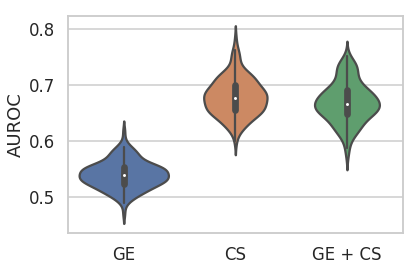

In [53]:
ax = sns.violinplot(data=pd.DataFrame({'GE': aurocs_GE, 
                                  'CS': aurocs_CS,
                                  'GE + CS': aurocs_GECS,
                                 }))
ax.set_ylabel('AUROC');

In [46]:
auroc_df = pd.DataFrame({'auroc': aurocs_GECS}, index=sider_df.columns[mask_ADR_to_predict])
# Most predictable ADRs
auroc_df.sort_values('auroc', ascending=False).head()

,auroc
Anaphylactoid reaction,0.747516
Eosinophilia,0.746875
Neutropenia,0.743902
Agranulocytosis,0.743180
Stomatitis,0.739922


In [47]:
# Least predictable ADRs
auroc_df.sort_values('auroc').head()

,auroc
Discomfort,0.571963
Shock,0.602563
Dry skin,0.618516
Respiratory tract infection,0.620866
Bronchospasm,0.620998
